# Preliminary Analysis with Maxfiltered and Bulk-Preprocessed Data

##### Last edited AXL 23/10/23

This jupyter notebook contains some preliminary 'analyses'/visualisation of the COINS-MEG MEG data. The inputted data is the maxfiltered and bulk-preprocessed version. 

## Load packages and data

In [1]:
# Load packages

from matplotlib import pyplot as plt

import mne
import osl
import numpy as np
import os

from pprint import pprint
import glob
import pandas as pd
from mne.preprocessing import create_eog_epochs, create_ecg_epochs

In [2]:
# Read in the data ####
#basedir = '/Users/amyli/Desktop/LH-lab/coins-meg_meg-analysis/'
basedir = '/ohba/pi/lhunt/datasets/coins-meg_meg-analysis'
subj = 12
run = 2
ifMaxfiltered = True # set to true so that directories point to maxfiltered data

In [3]:
# Set directory paths
procdir = os.path.join(basedir, 'preprocessed') # directory for the processed data

if ifMaxfiltered == False:
    dir_meg = os.path.join(procdir, f'sub-{subj}', f'run-{run}', 'meg', 'nomax')
else:
    dir_meg = os.path.join(procdir, f'sub-{subj}', f'run-{run}', 'meg', 'auto-max')  # folder where auto-preproc, maxfiltered versions live

dir_meg_derivatives = os.path.join(dir_meg, 'derivatives') # for storing derivatives from processing (eg fif files)
dir_meg_plots = os.path.join(dir_meg, 'plots') # for storing plots generated during preprocessing

print(procdir)
print(dir_meg)
print(dir_meg_derivatives)

# generate the output directory if it doesn't exist
os.makedirs(dir_meg_derivatives, exist_ok=True)
os.makedirs(dir_meg_plots, exist_ok=True)


/ohba/pi/lhunt/datasets/coins-meg_meg-analysis/preprocessed
/ohba/pi/lhunt/datasets/coins-meg_meg-analysis/preprocessed/sub-12/run-2/meg/auto-max
/ohba/pi/lhunt/datasets/coins-meg_meg-analysis/preprocessed/sub-12/run-2/meg/auto-max/derivatives


In [4]:
# Read in the MEG data

# Get the filename for a specific subject and run
if ifMaxfiltered == False:
    preproc_fname = os.path.join(dir_meg_derivatives,
                                 f'sub-{subj}_ses-2-meg_task-coinsmeg_run-{run}_meg_preproc_raw.fif')
else:
    preproc_fname = os.path.join(procdir, 'auto-max', f'sub-{subj}_ses-2-meg_task-coinsmeg_run-{run}_meg_transsss',
                                 f'sub-{subj}_ses-2-meg_task-coinsmeg_run-{run}_meg_transsss_preproc_raw.fif')
    ica_fname = os.path.join(procdir, 'auto-max', f'sub-{subj}_ses-2-meg_task-coinsmeg_run-{run}_meg_transsss',
                                 f'sub-{subj}_ses-2-meg_task-coinsmeg_run-{run}_meg_transsss_ica.fif')

print(preproc_fname)
print(ica_fname)

/ohba/pi/lhunt/datasets/coins-meg_meg-analysis/preprocessed/auto-max/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss_preproc_raw.fif
/ohba/pi/lhunt/datasets/coins-meg_meg-analysis/preprocessed/auto-max/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss_ica.fif


In [5]:
clean = mne.io.read_raw_fif(preproc_fname, preload=True)

Opening raw data file /ohba/pi/lhunt/datasets/coins-meg_meg-analysis/preprocessed/auto-max/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss_preproc_raw.fif...
    Range : 61000 ... 853999 =     61.000 ...   853.999 secs
Ready.
Reading 0 ... 792999  =      0.000 ...   792.999 secs...


In [6]:
ica = mne.preprocessing.read_ica(ica_fname)
ica

Reading /ohba/pi/lhunt/datasets/coins-meg_meg-analysis/preprocessed/auto-max/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss/sub-12_ses-2-meg_task-coinsmeg_run-2_meg_transsss_ica.fif ...
Now restoring ICA solution ...
Ready.


<ICA | raw data decomposition, method: fastica (fit in 109 iterations on 729801 samples), 64 ICA components (306 PCA components available), channel types: mag, grad, 2 sources marked for exclusion>

## Laser Hit vs Miss Analysis

### Defining and Processing Epochs  

2916 events found
Event IDs: [  1   2   3   4   5   6   7  10  20 100 105]
Not setting metadata
2906 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  2906 events (good & bad), -0.5 - 1 sec, baseline -0.5 – 0 sec, ~6.4 MB, data not loaded,
 'laserHit': 1480
 'laserMiss': 576
 'keyRight': 215
 'keyLeft': 182
 'keyUp': 27
 'keyDown': 22
 'keyRelease': 404>
Using data from preloaded Raw for 2906 events and 1501 original time points ...
571 bad epochs dropped


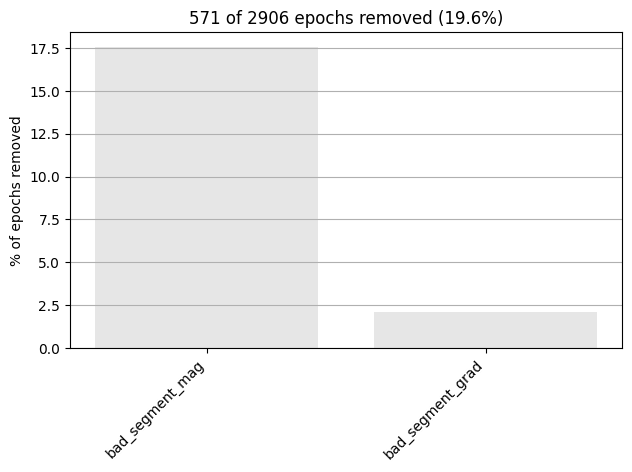

In [7]:
# Define the events 
events = mne.find_events(clean, min_duration=0.005)
event_color = {}
event_dict = {'laserHit': 1, 'laserMiss': 2, 'keyRight': 3, 'keyLeft': 4, 'keyUp': 5, 'keyDown': 6, 'keyRelease': 7}

# Create epochs (-0.5 to 1.0s epoch around event) 
epochs = mne.Epochs(clean, events, tmin=-0.5, tmax=1.0, event_id=event_dict) # -0.5-1.0
print(epochs)

# Remove epochs with particularly high peak-to-peak amplitudes, as this indicates there might still
# be segments in the data with high variance, that we didn't find earlier. We also include EOG peak-to-peak
# amplitude, as high amplitudes indicate saccades.
epochs.drop_bad({"eog": 6e-4, "mag": 4e-11, "grad": 4e-10}) # defines specific thresholds for peak-to-peak amplitudes in different types of channels

# Plot % of epochs dropped
epochs.plot_drop_log();

In [8]:
# Use equalize_event_counts() to randomly sample epochs from each condition to match the number
# of epochs present in the condition w/ the fewest good epochs
conditions = ["laserHit", "laserMiss"]
epochs.equalize_event_counts(conditions)

hit_epochs = epochs["laserHit"]
miss_epochs = epochs["laserMiss"]

Dropped 669 epochs: 67, 68, 69, 70, 71, 74, 80, 84, 85, 86, 87, 88, 89, 90, 97, 99, 101, 104, 107, 109, 111, 112, 113, 114, 117, 119, 121, 122, 123, 124, 125, 126, 140, 141, 144, 147, 156, 158, 163, 165, 167, 173, 175, 190, 214, 215, 216, 217, 218, 219, 222, 225, 228, 229, 230, 231, 233, 234, 235, 242, 245, 246, 247, 248, 251, 252, 253, 254, 257, 258, 261, 264, 265, 268, 269, 270, 271, 272, 273, 277, 279, 282, 283, 284, 287, 288, 289, 298, 299, 300, 301, 302, 307, 308, 311, 312, 313, 322, 328, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 343, 344, 345, 346, 347, 348, 349, 352, 353, 354, 357, 358, 359, 364, 366, 368, 371, 372, 375, 376, 377, 378, 379, 382, 383, 384, 385, 388, 389, 390, 391, 392, 395, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 413, 420, 421, 422, 424, 426, 427, 428, 429, 430, 433, 436, 437, 446, 449, 450, 453, 468, 473, 480, 481, 482, 494, 495, 496, 497, 500, 501, 502, 503, 504, 505, 506, 508, 509, 510, 511, 513, 514, 515, 516, 517, 5

### Visualising Evoked Potential for Laser Hits

First visualise ERFs for all channels, for both magnetometers and gradiometers.

No projector specified for this dataset. Please consider the method self.add_proj.


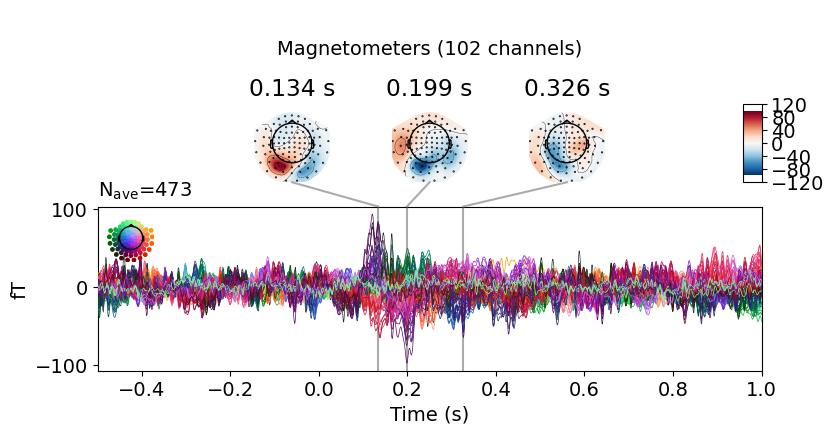

No projector specified for this dataset. Please consider the method self.add_proj.


<Figure size 640x480 with 0 Axes>

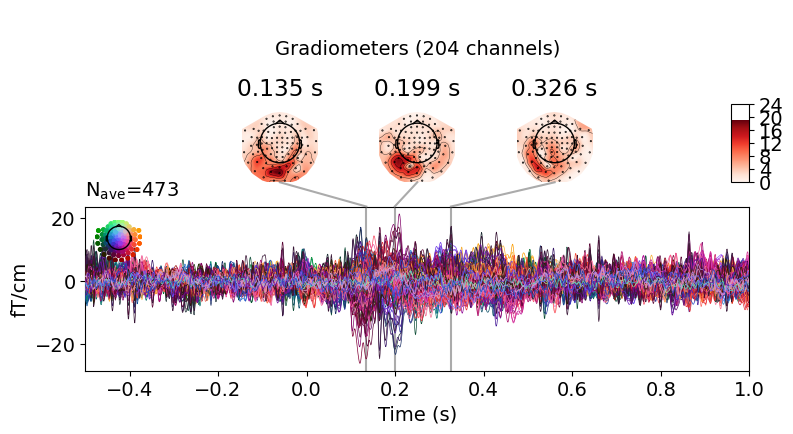

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

# Compute average evoked responses for hit and miss epochs

## hit ERFs
evoked_hit = hit_epochs.average()

evoked_hit.plot_joint(picks='mag')
plt.savefig(os.path.join(dir_meg_plots, 'erf-joint-mag_laserHit.png'), format='png')

evoked_hit.plot_joint(picks='grad')
plt.savefig(os.path.join(dir_meg_plots, 'erf-joint-grad_laserHit.png'), format='png');

### Visualising Evoked Potential for Laser Misses

First visualise ERFs for all channels, for both magnetometers and gradiometers.

No projector specified for this dataset. Please consider the method self.add_proj.


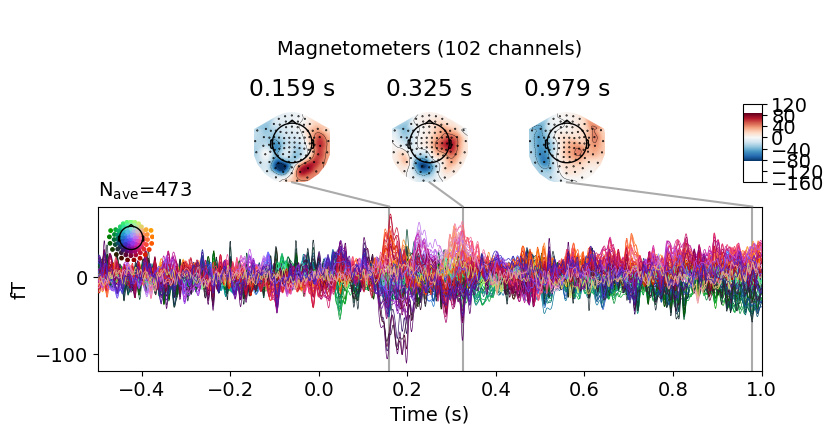

No projector specified for this dataset. Please consider the method self.add_proj.


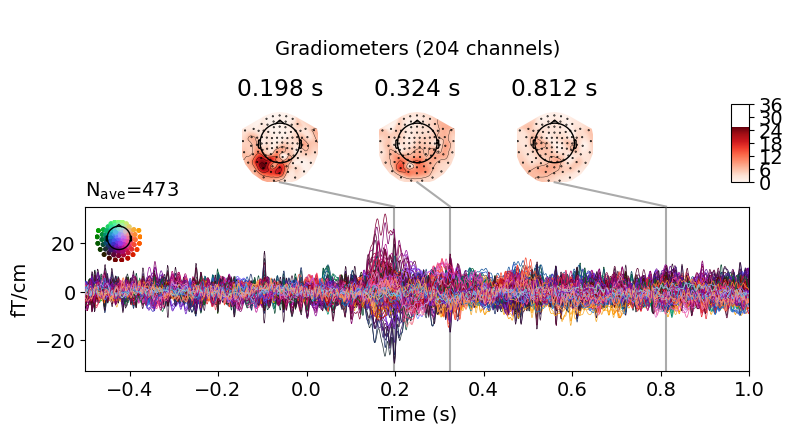

In [10]:
## miss ERFs
evoked_miss = miss_epochs.average()

evoked_miss.plot_joint(picks='mag')

evoked_miss.plot_joint(picks='grad');


### Comparing Laser Hits vs Misses

First compare global field power for hits vs. misses; for both magnetometers and gradiometers.

combining channels using "gfp"
combining channels using "gfp"


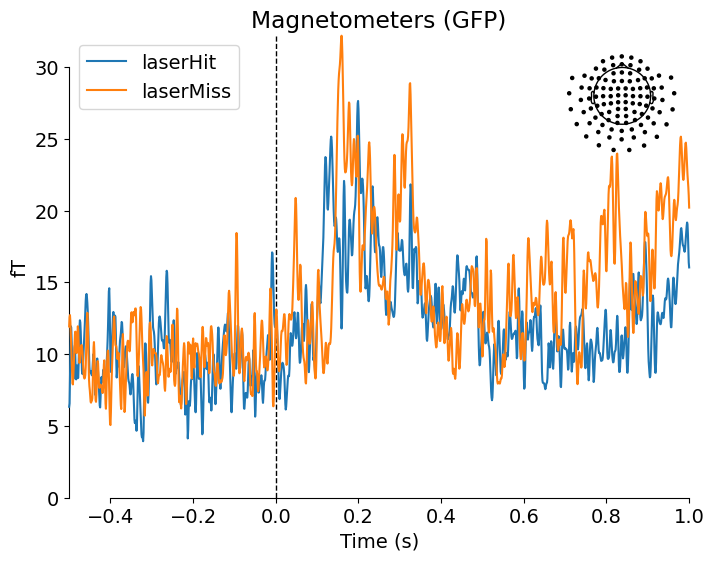

combining channels using "gfp"
combining channels using "gfp"


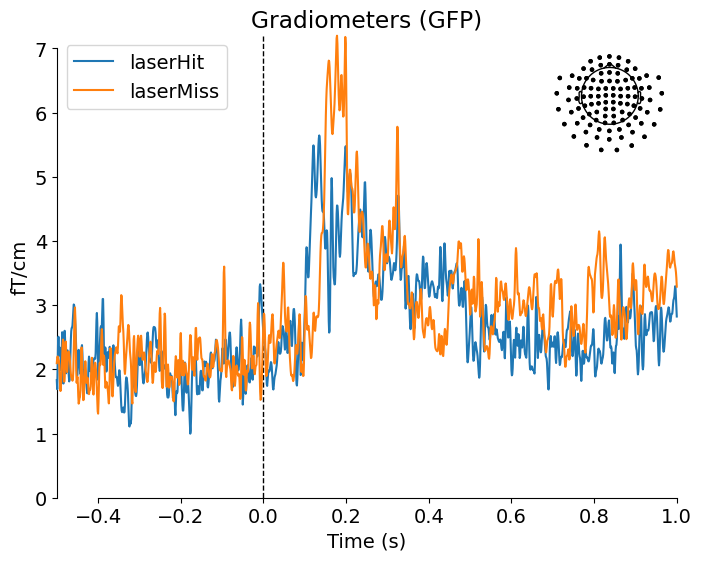

[<Figure size 800x600 with 2 Axes>]

In [11]:
## Compare hit vs miss evokeds, global field power

mne.viz.plot_compare_evokeds([evoked_hit, evoked_miss], picks='mag',
                             show_sensors='upper right')

mne.viz.plot_compare_evokeds([evoked_hit, evoked_miss], picks='grad',
                             show_sensors='upper right')

#### Plot difference waveform for laser hits vs misses

For all sensors...

No projector specified for this dataset. Please consider the method self.add_proj.


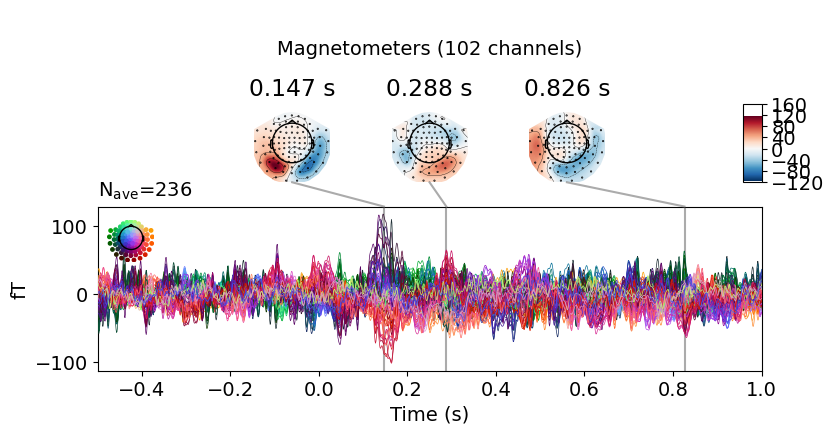

No projector specified for this dataset. Please consider the method self.add_proj.


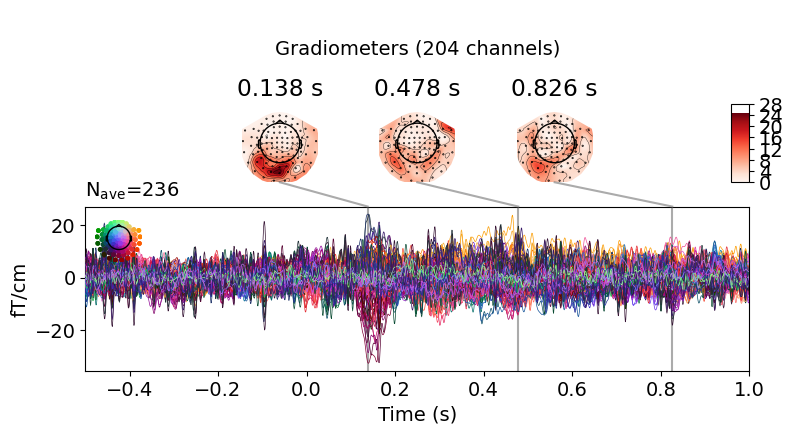

In [12]:
## difference waveform hit-miss

### all sensors and topography
evokeds_diff_hitVsMiss = mne.combine_evoked([evoked_hit, evoked_miss], weights=[1, -1])
evokeds_diff_hitVsMiss.plot_joint(picks='mag')
evokeds_diff_hitVsMiss.plot_joint(picks='grad');

## Movement Keys (Left vs. Right) Analysis

### Defining and Processing Epochs

Not setting metadata
2906 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  2906 events (good & bad), -3 - 1 sec, baseline off, ~6.4 MB, data not loaded,
 'laserHit': 1480
 'laserMiss': 576
 'keyRight': 215
 'keyLeft': 182
 'keyUp': 27
 'keyDown': 22
 'keyRelease': 404>
Using data from preloaded Raw for 2906 events and 4001 original time points ...
1026 bad epochs dropped


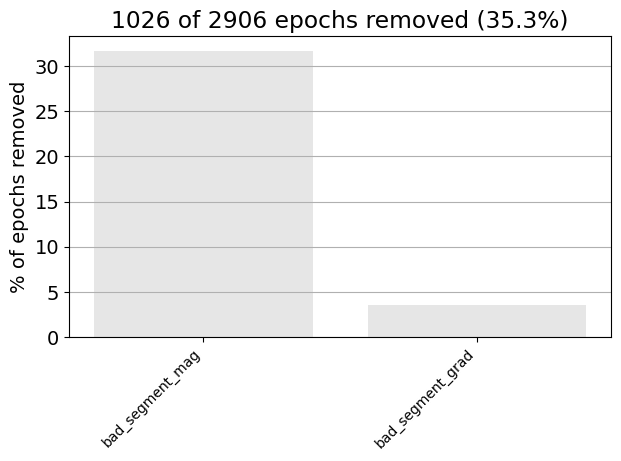

Dropped 33 epochs: 54, 74, 77, 81, 84, 87, 97, 101, 106, 125, 130, 132, 135, 142, 147, 153, 158, 162, 167, 171, 186, 192, 212, 222, 231, 372, 392, 395, 401, 436, 445, 490, 498


In [13]:
# Create epochs for movement keys (left vs right); no baselining applied

epochs = mne.Epochs(clean, events, baseline=None, tmin=-3.0, tmax=1.0, event_id=event_dict) # different epoch times now compared to hit/miss
print(epochs)

# Remove epochs with particularly high peak-to-peak amplitudes, as we did for hit/miss epochs

epochs.drop_bad({"eog": 6e-4, "mag": 4e-11, "grad": 4e-10}) # defines specific thresholds for peak-to-peak amplitudes in different types of channels
epochs.plot_drop_log();

# use equalize_event_counts first to randomly sample epochs from each condition to match the number
# of epochs present in the condition w/ the fewest good epochs
conditions = ["keyLeft", "keyRight"]
epochs.equalize_event_counts(conditions)

left_epochs = epochs["keyLeft"]
right_epochs = epochs["keyRight"]

### Visualising Evoked Potentials for keyLeft

No projector specified for this dataset. Please consider the method self.add_proj.


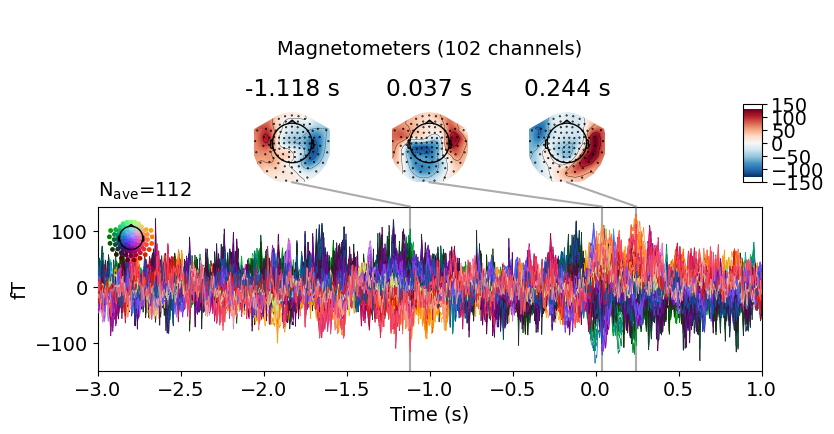

No projector specified for this dataset. Please consider the method self.add_proj.


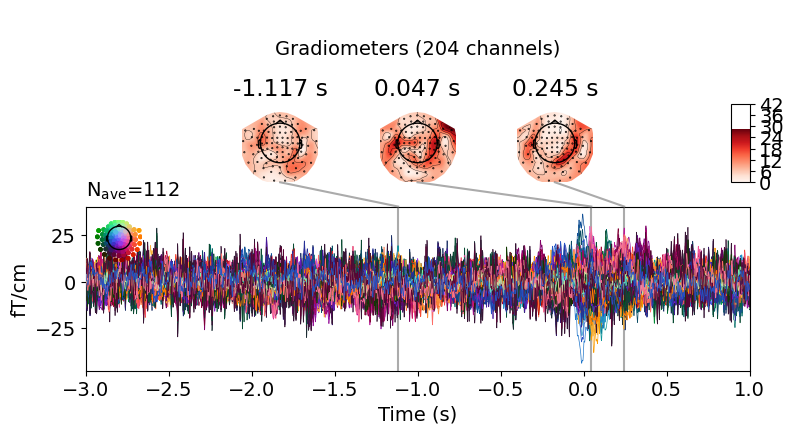

In [14]:
# Compute average evoked responses for left and right epochs

evoked_left = left_epochs.average()
evoked_left.plot_joint(picks='mag')

evoked_left.plot_joint(picks='grad');

### Visualising Evoked Potentials for keyRight

No projector specified for this dataset. Please consider the method self.add_proj.


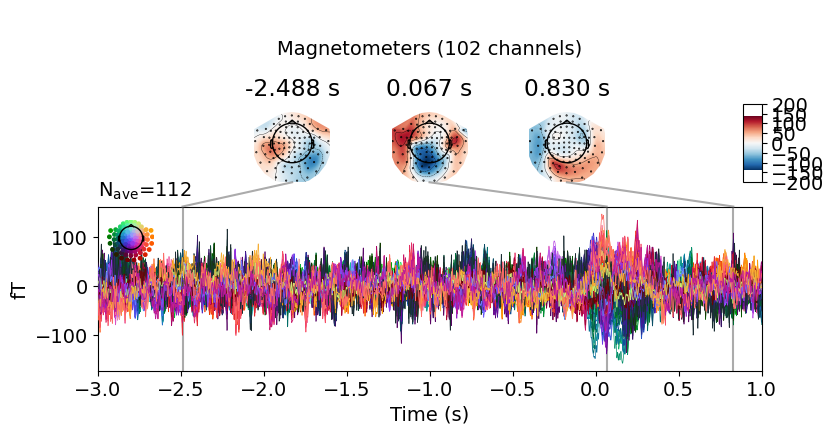

No projector specified for this dataset. Please consider the method self.add_proj.


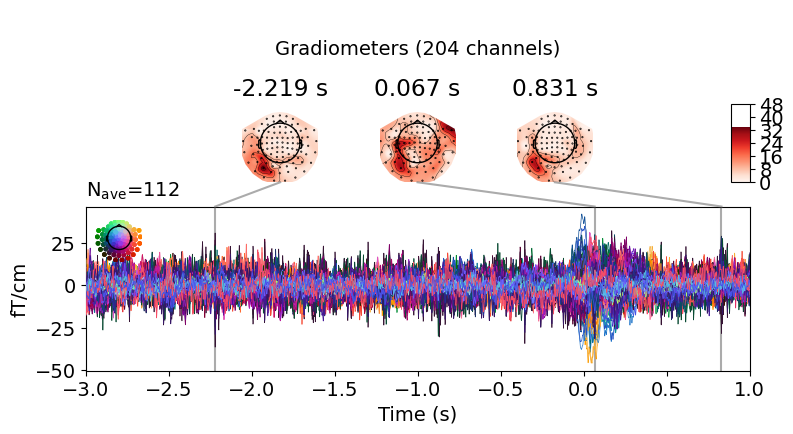

In [15]:
evoked_right = right_epochs.average()

evoked_right.plot_joint(picks='mag')

evoked_right.plot_joint(picks='grad');

### Comparing KeyLeft vs Right

First compare global field power for keyLeft vs. Right; for both magnetometers and gradiometers.

combining channels using "gfp"
combining channels using "gfp"


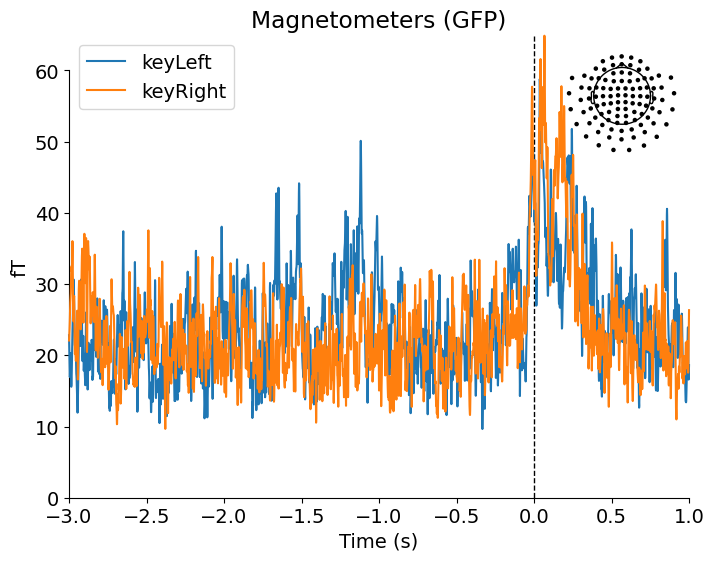

combining channels using "gfp"
combining channels using "gfp"


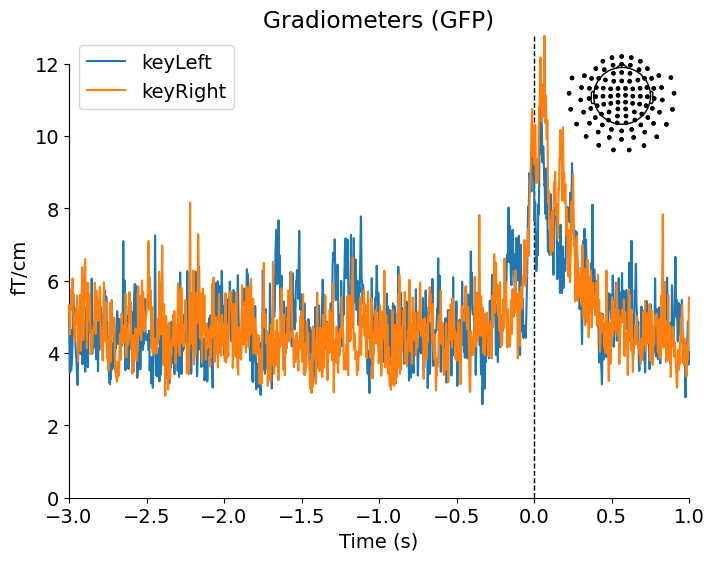

In [16]:
mne.viz.plot_compare_evokeds([evoked_left, evoked_right], picks='mag',
                             show_sensors='upper right')

mne.viz.plot_compare_evokeds([evoked_left, evoked_right], picks='grad',
                             show_sensors='upper right');

No projector specified for this dataset. Please consider the method self.add_proj.


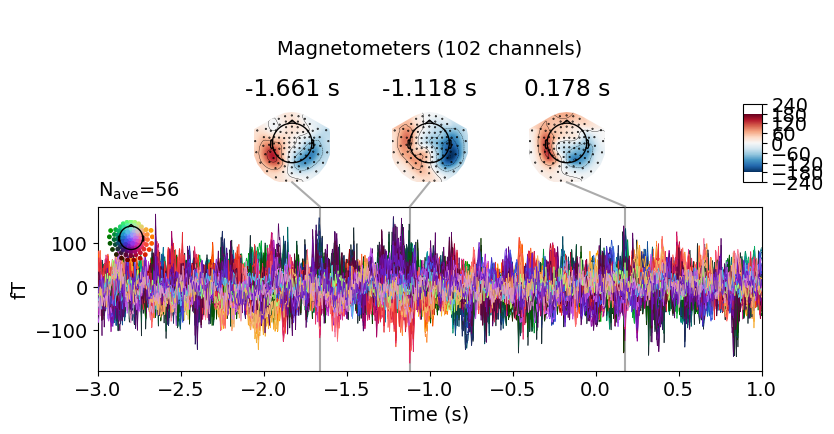

No projector specified for this dataset. Please consider the method self.add_proj.


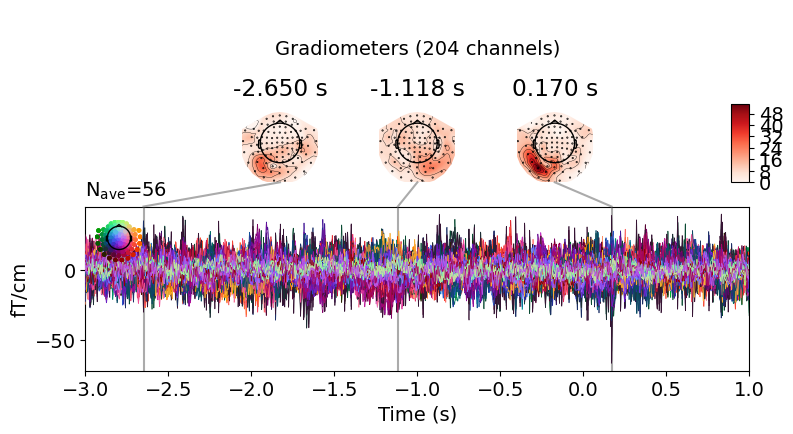

In [17]:
evokeds_diff_leftVsRight = mne.combine_evoked([evoked_left, evoked_right], weights=[1, -1])
evokeds_diff_leftVsRight.plot_joint(picks='mag')

evokeds_diff_leftVsRight.plot_joint(picks='grad');

## Shield Size Keys (Up vs. Down) Analysis

In [18]:
# Don't need to redefine epochs; used the previous non-baselined ones again from keyleft vs right

# use equalize_event_counts first to randomly sample epochs from each condition to match the number
# of epochs present in the condition w/ the fewest good epochs
conditions = ["keyUp", "keyDown"]
epochs.equalize_event_counts(conditions)

up_epochs = epochs["keyUp"]
down_epochs = epochs["keyDown"]

Dropped 5 epochs: 41, 457, 563, 574, 1039


### Visualising Evoked Potentials for keyUp

No projector specified for this dataset. Please consider the method self.add_proj.


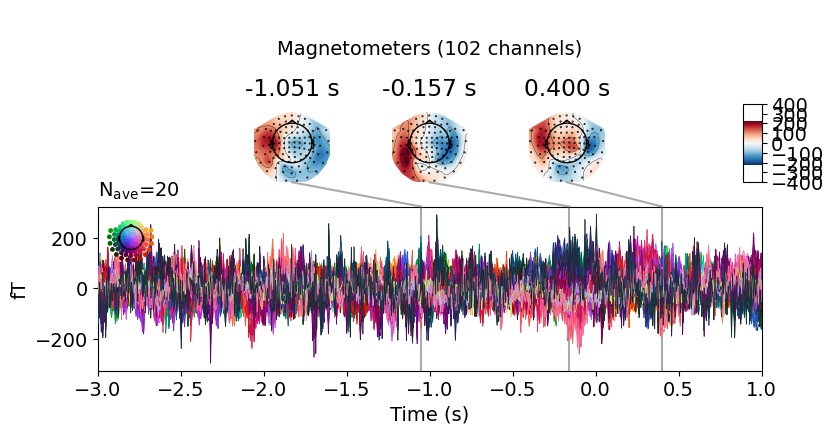

No projector specified for this dataset. Please consider the method self.add_proj.


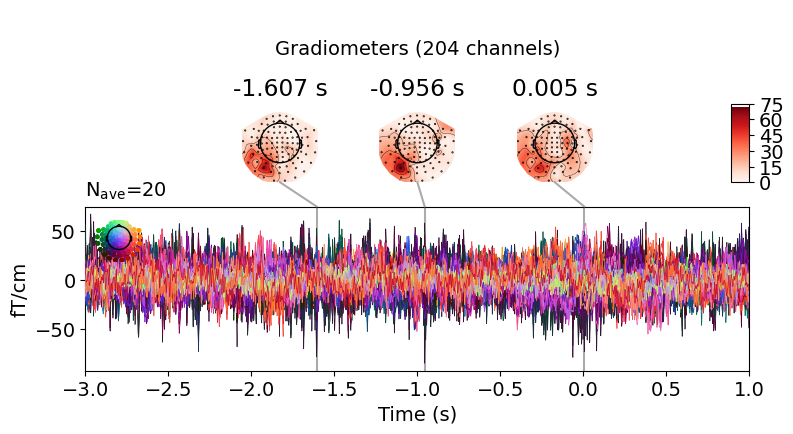

In [19]:
### Visualising Evoked Potentials for keyUp

# Compute average evoked responses for up and down epochs

evoked_up = up_epochs.average()

evoked_up.plot_joint(picks='mag')

evoked_up.plot_joint(picks='grad');

### Visualising Evoked Potentials for KeyDown

No projector specified for this dataset. Please consider the method self.add_proj.


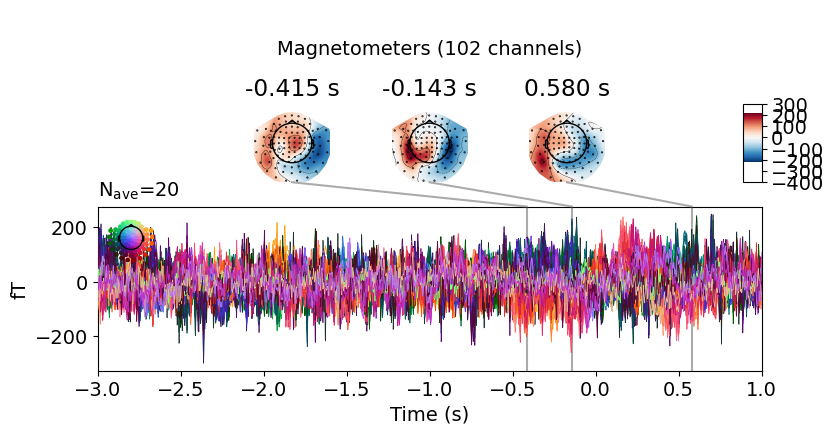

No projector specified for this dataset. Please consider the method self.add_proj.


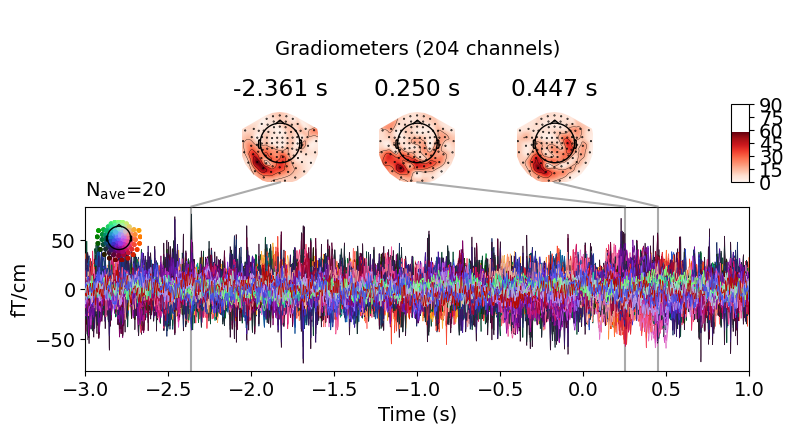

In [20]:

evoked_down = down_epochs.average()

evoked_down.plot_joint(picks='mag')

evoked_down.plot_joint(picks='grad');


### Comparing KeyUp vs Down

First compare global field power for keyUp vs. Down; for both magnetometers and gradiometers.

combining channels using "gfp"
combining channels using "gfp"


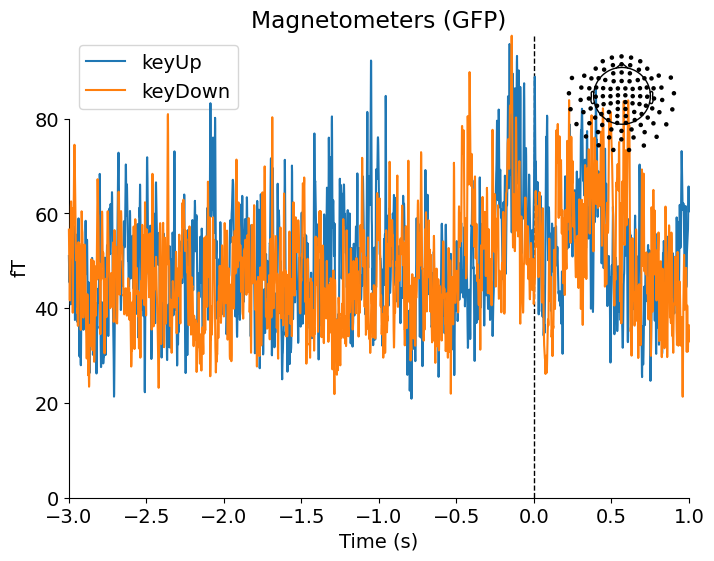

combining channels using "gfp"
combining channels using "gfp"


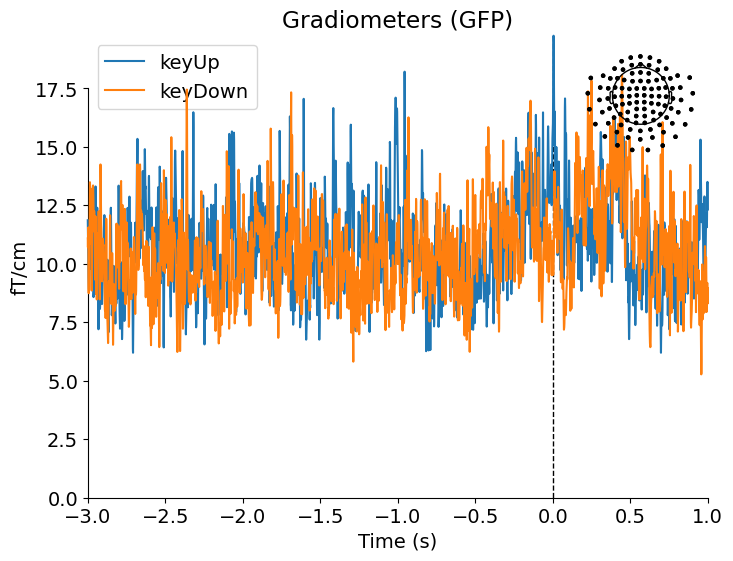

In [21]:
mne.viz.plot_compare_evokeds([evoked_up, evoked_down], picks='mag',
                             show_sensors='upper right')

mne.viz.plot_compare_evokeds([evoked_up, evoked_down], picks='grad',
                             show_sensors='upper right');

No projector specified for this dataset. Please consider the method self.add_proj.


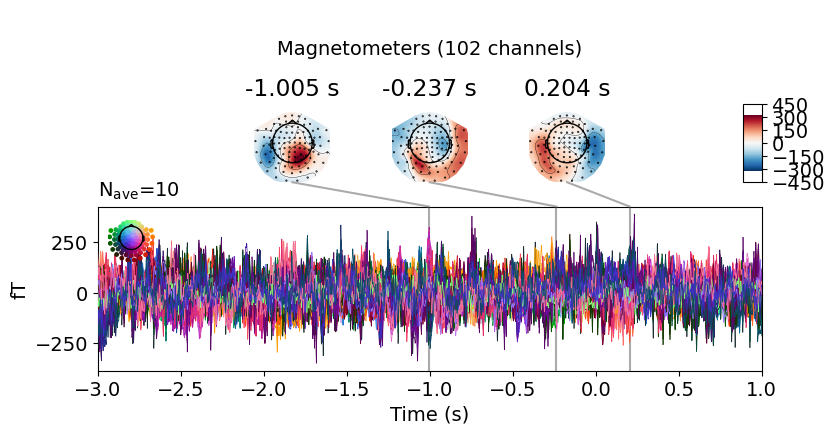

No projector specified for this dataset. Please consider the method self.add_proj.


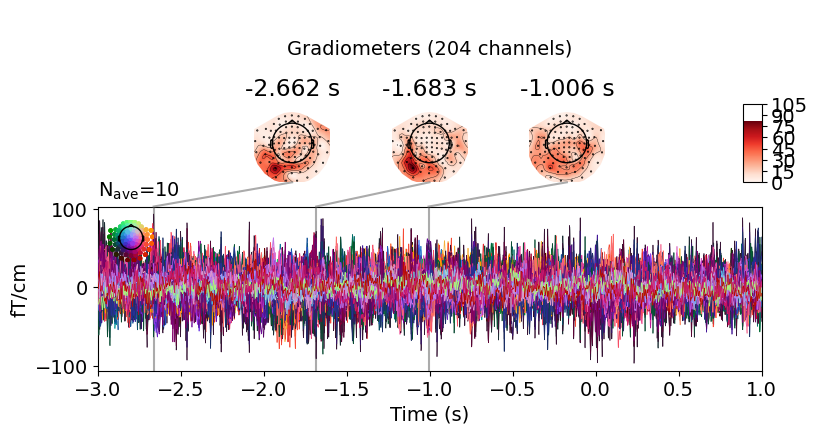

In [22]:
evokeds_diff_leftVsRight = mne.combine_evoked([evoked_up, evoked_down], weights=[1, -1])

evokeds_diff_leftVsRight.plot_joint(picks='mag')

evokeds_diff_leftVsRight.plot_joint(picks='grad');